C:\Users\vedan\AppData\Local\Temp\ipykernel_17724\2359065143.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')


Mean Squared Error (All Cities preview): 91293483721.23544
R² Score (All Cities preview): -1.7975033567558456
[Boston] MSE: 1557955396.6807141
[Boston] R²: -2.739997749668656


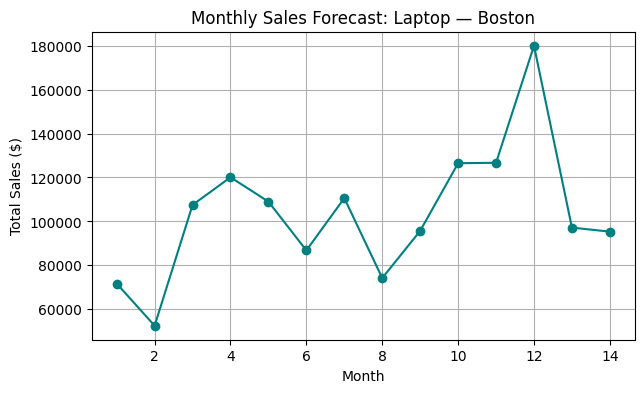

In [2]:
# Step 1: Imports
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

import tkinter as tk
from tkinter import ttk

# Step 2: Load & Prepare Pivot Data (if not already loaded)
df = pd.read_csv("C:/CloutThat/Main_project/12 month+1data.csv")
df = df.drop_duplicates()
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
df = df.dropna(subset=['Order Date'])
df['Product'] = df['Product'].str.strip().str.title()
df['Month'] = df['Order Date'].dt.month
df['Total Price'] = df['Quantity Ordered'] * df['Price Each']

# (ADDED) City column (keeps it simple)
if 'City' not in df.columns:
    def city_from_addr(a):
        try:
            return str(a).split(',')[-2].strip()
        except:
            return 'Unknown'
    df['City'] = df.get('Purchase Address', pd.Series(['Unknown']*len(df))).apply(city_from_addr)

# Categorize Product Type
def get_product_type(product):
    product = product.lower()
    if 'phone' in product:
        return 'Phone'
    elif 'headphone' in product or 'ear' in product:
        return 'Audio'
    elif 'charger' in product or 'cable' in product:
        return 'Accessory'
    elif 'monitor' in product or 'screen' in product:
        return 'Display'
    elif 'macbook' in product or 'laptop' in product:
        return 'Laptop'
    elif 'keyboard' in product or 'mouse' in product:
        return 'Input'
    else:
        return 'Other'

df['Product Type'] = df['Product'].apply(get_product_type)

# Aggregate and Pivot Data (ALL cities once — just to get initial product list)
monthly_sales_all = df.groupby(['Month', 'Product Type'])['Total Price'].sum().reset_index()
sales_pivot_all = monthly_sales_all.pivot(index='Month', columns='Product Type', values='Total Price').fillna(0)
product_types_all = list(sales_pivot_all.columns)  # used for dropdown and consistent columns

# Step 3: Create lag features with current month (for ALL cities preview only)
n_lags = 3
X, y = [], []
sales_pivot_reset = sales_pivot_all.reset_index()

for i in range(n_lags, len(sales_pivot_reset)):
    lagged = sales_pivot_reset.iloc[i-n_lags:i][sales_pivot_all.columns].values.flatten()
    current_month = [sales_pivot_reset.loc[i, 'Month']]
    features = np.concatenate((lagged, current_month))
    X.append(features)
    y.append(sales_pivot_reset.iloc[i][sales_pivot_all.columns].values)

X = np.array(X)
y = np.array(y)

# Step 4: Train/test split
if len(X) >= 3:
    X_train, y_train = X[:-2], y[:-2]
    X_test, y_test = X[-2:], y[-2:]
else:
    X_train, y_train, X_test, y_test = X, y, X, y

# Step 5: Train the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
if len(X_train) > 0:
    rf.fit(X_train, y_train)

# Step 6: Predict and evaluate (optional preview on ALL cities)
if len(X_test) > 0:
    y_pred = rf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
else:
    mse = np.nan
    r2 = np.nan

# Step 7: (optional) Preview plot for ALL cities — skipped to keep it simple

# Step 8: Show performance metrics — printed once for ALL cities (optional)
print("Mean Squared Error (All Cities preview):", mse)
print("R² Score (All Cities preview):", r2)

# Step 9: Predict future sales for Month 13 and 14 — will be redone per City in UI

# -------------------- TKINTER (just like your pattern, plus City) --------------------
root = tk.Tk()
root.title("📈 Product Sales Forecast Viewer (Simple + City)")
root.geometry("780x540")

# (ADDED) City dropdown values
cities = ['All Cities'] + sorted(df['City'].dropna().unique().tolist())

# Top controls
top = tk.Frame(root); top.pack(pady=10)

# City dropdown
tk.Label(top, text="City:").grid(row=0, column=0, padx=6)
selected_city = tk.StringVar()
city_dd = ttk.Combobox(top, textvariable=selected_city, values=cities, state="readonly", width=28)
city_dd.set(cities[0])
city_dd.grid(row=0, column=1, padx=6)

# Product dropdown (from ALL product types to keep it simple)
tk.Label(top, text="Product Type:").grid(row=0, column=2, padx=6)
selected_product = tk.StringVar()
product_dd = ttk.Combobox(top, textvariable=selected_product, values=product_types_all, state="readonly", width=28)
product_dd.set(product_types_all[0])
product_dd.grid(row=0, column=3, padx=6)

canvas = None

def plot_sales():
    global canvas

    # Clear old canvas if any
    if canvas:
        canvas.get_tk_widget().destroy()
        canvas = None

    # ====== Re-run your same pipeline but FILTERED by selected city ======
    d = df.copy()
    city_choice = selected_city.get()
    if city_choice != 'All Cities':
        d = d[d['City'] == city_choice]

    # Aggregate & Pivot Data (for this city)
    monthly_sales = d.groupby(['Month', 'Product Type'])['Total Price'].sum().reset_index()
    sales_pivot = monthly_sales.pivot(index='Month', columns='Product Type', values='Total Price').fillna(0)
    # Ensure consistent columns so product dropdown always works
    sales_pivot = sales_pivot.reindex(columns=product_types_all, fill_value=0)
    sales_pivot_reset = sales_pivot.reset_index()

    # Step 3: Create lag features with current month
    n_lags = 3
    X, y = [], []
    for i in range(n_lags, len(sales_pivot_reset)):
        lagged = sales_pivot_reset.iloc[i-n_lags:i][sales_pivot.columns].values.flatten()
        current_month = [sales_pivot_reset.loc[i, 'Month']]
        features = np.concatenate((lagged, current_month))
        X.append(features)
        y.append(sales_pivot_reset.iloc[i][sales_pivot.columns].values)
    X = np.array(X); y = np.array(y)

    # Step 4 & 5: Train
    if len(X) >= 3:
        X_train, y_train = X[:-2], y[:-2]
        X_test, y_test = X[-2:], y[-2:]
    else:
        X_train, y_train, X_test, y_test = X, y, X, y

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    if len(X_train) > 0:
        rf.fit(X_train, y_train)

    # Step 6: Predict and evaluate (optional)
    if len(X_test) > 0:
        y_pred = rf.predict(X_test)
        print(f"[{city_choice}] MSE:", mean_squared_error(y_test, y_pred))
        print(f"[{city_choice}] R²:", r2_score(y_test, y_pred))

    # Step 9: Predict future sales for Month 13 and 14
    input_data = sales_pivot_reset.iloc[-n_lags:][sales_pivot.columns].values.flatten() if len(sales_pivot_reset) >= n_lags else np.zeros(n_lags*len(sales_pivot.columns))
    future_predictions = []
    for next_month in [13, 14]:
        features = np.concatenate((input_data[-3 * len(sales_pivot.columns):], [next_month]))
        pred = rf.predict([features])[0] if len(X_train) > 0 else np.zeros(len(sales_pivot.columns))
        future_predictions.append(pred)
        input_data = np.concatenate((input_data, pred))

    future_df = pd.DataFrame(future_predictions, columns=sales_pivot.columns, index=[13, 14])
    future_df.index.name = "Month"
    future_df = future_df.round(2)

    # Combine actual and predicted
    full_sales = pd.concat([sales_pivot, future_df])

    # ----- Plot selected product (same style as yours) -----
    product = selected_product.get()

    import matplotlib.pyplot as plt
    from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(full_sales.index, full_sales[product], marker='o', color='teal')
    ax.set_title(f"Monthly Sales Forecast: {product} — {city_choice}")
    ax.set_xlabel("Month"); ax.set_ylabel("Total Sales ($)")
    ax.grid(True)

    canvas_local = FigureCanvasTkAgg(fig, master=root)
    canvas_local.draw()
    canvas_local.get_tk_widget().pack(pady=20)

    # keep ref so we can destroy next time
    globals()['canvas'] = canvas_local

# Button (same pattern as yours)
btn = tk.Button(root, text="Show Chart", command=plot_sales, font=("Arial", 11), bg="skyblue")
btn.pack(pady=6)

root.mainloop()